# Description
Consider the following scenario: a process generates a set of sequences, each sequences is encoded as a sequence of characters. There is an undisclosed number of distinct processes so it should be possible to group the sequences into clusters of similar sequences. However, in addition some sequences have been generated by another unrelated process to form outliers. Each instance is either an inlier or an outlier.

**Task 1:** Cluster the inliers into an appropriate number of groups.

**Task 2:** Generate a novel prototypical sequence for each cluster, i.e. a sequence that is the most representative for that cluster. Note that the prototypical sequence must be novel, i.e. not be one of the provided sequences.

**Data:** A text file, test.txt, is provided which contains a random mixture of inlier and outlier sequences in no particular order. Each row of this contains an integer identifier for the sequence and the sequence itself.  

**Outputs:**
1. Print for each sequence's identifier together with the cluster ID they belong to or that they are an outlier.
2. Print one novel prototypical sequence for each cluster you have found.

# Sequence Clustering Task
Since this notebook is run in Google Colab, we can simply upload the file to be processed rather than mounting Drive (which requires additional permissions). We then import any required libraries.

In [ ]:
# Upload the text file
from google.colab import files
files.upload()

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

We parse the text file and split each instance as identifier and sequence.

In [3]:
# Parse the text data
data = []
with open('test.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 1)
        identifier = int(parts[0])
        sequence = parts[1]
        data.append((identifier, sequence))

### Data preprocessing
1. Extract each sequence in `sequences`.
2. Use padding to ensure that the sequences have equal lengths for our clustering algorithm. Pad shorter sequences with spaces on the right and store all of them in `padded_sequences`.
3. Define a function `sequence_to_numeric()` to convert a sequence of characters into its numerical representation and store the outputs in `numeric_sequences` list.

In [4]:
# Extract the sequences
sequences = [sequence for _, sequence in data]

# Pad sequences to the length of the longest sequence
max_length = max(len(sequence) for sequence in sequences)
padded_sequences = [sequence.ljust(max_length, ' ') for sequence in sequences]

# Convert sequences to numerical representation
def sequence_to_numeric(sequence):
    return np.array([ord(char) for char in sequence])

# Store all numeric conversions in a list
numeric_sequences = [sequence_to_numeric(sequence) for sequence in padded_sequences]

### Average distance plot
1. Fit the `NearestNeighbors` model to the numerical sequences.
2. Calculate the average distance from each data point to its 10 nearest neighbours and sort the output array in ascending order.
3. Display the plot for 'data point index' vs 'average distance to 10 nearest neighbours' to check for knee point.


[18.6201364  18.75582127 18.91267292 ... 35.38053541 35.76660315
 35.8857527 ]


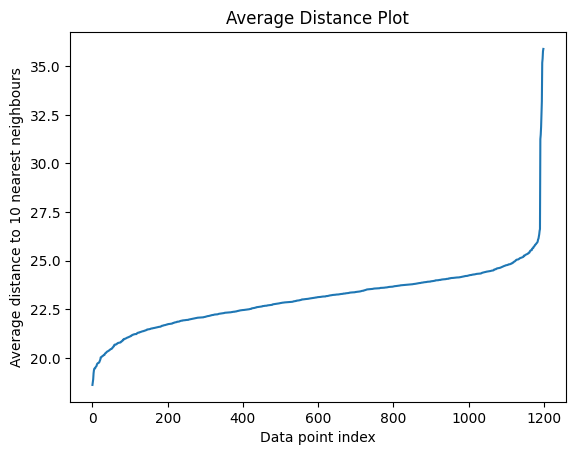

In [5]:
# Compute average nearest neighbour distances to determine optimal eps
nn = NearestNeighbors(n_neighbors=10)
nn.fit(numeric_sequences)
distances, _ = nn.kneighbors(numeric_sequences)
avg_distances = np.mean(distances, axis=1)
avg_distances.sort()
print(avg_distances)

# Display the average distance plot
plt.plot(avg_distances)
plt.title("Average Distance Plot")
plt.xlabel("Data point index")
plt.ylabel("Average distance to 10 nearest neighbours")
plt.show()

### Model fitting and outputs
1. Calculate the best epsilon value using `knee_point_index` via the average distance plot.
2. We set `min_samples` to be a proportion of the total number of data points. Take 1% (12 sequences) as the `min_samples` value in this case.
3. Use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm for clustering and get the `cluster_labels` array, where each element represents the cluster label assigned to the corresponding data point/instance.
4. Create a dictionary as {cluster label: [identifier, identifier, ...]} to map each sequence to a cluster based on the computed label. Print corresponding identifiers for all clusters and outliers.

In [6]:
# Get the best epsilon value based on the knee point
knee_point_index = np.argmax(np.diff(avg_distances)) + 1
best_eps = avg_distances[knee_point_index]

# Choose 1% min_samples from the number of data points
min_samples = int(len(numeric_sequences) * 0.01)

# Perform clustering with the optimal parameters
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(numeric_sequences)

# Map sequences to clusters
clusters = {}
for identifier, cluster_label in zip([identifier for identifier, _ in data], cluster_labels):
    if cluster_label not in clusters:
        clusters[cluster_label] = []
    clusters[cluster_label].append(identifier)

# Print clusters/outliers identifiers
print("Clusters, outliers, and corresponding identifiers:\n")
for cluster_label, identifiers in clusters.items():
    if cluster_label == -1:
        print(f"Outliers: {identifiers}")
    else:
        print(f"Cluster {cluster_label}: {identifiers}")

Clusters, outliers, and corresponding identifiers:

Outliers: [0, 20, 71, 193, 293, 333, 359, 395, 429, 503, 520, 527, 539, 557, 667, 997, 1085, 1131]
Cluster 0: [1, 13, 21, 88, 105, 114, 119, 124, 138, 146, 183, 204, 214, 242, 245, 265, 266, 282, 287, 291, 311, 349, 353, 358, 361, 368, 394, 399, 407, 434, 438, 443, 477, 478, 482, 487, 489, 505, 506, 509, 528, 543, 560, 576, 646, 676, 696, 699, 724, 730, 741, 801, 839, 853, 858, 862, 868, 892, 908, 918, 1004, 1029, 1036, 1038, 1052, 1061, 1062, 1068, 1098, 1107, 1111, 1119, 1140, 1171, 1197]
Cluster 1: [2, 27, 35, 98, 150, 232, 248, 273, 314, 342, 346, 369, 386, 415, 485, 518, 540, 558, 633, 698, 728, 900, 958, 970, 1044, 1078, 1087, 1128, 1133, 1169]
Cluster 2: [3, 174, 243, 247, 292, 377, 497, 660, 690, 831, 883, 911, 924, 967, 986, 1077]
Cluster 3: [4, 25, 57, 80, 92, 121, 127, 130, 149, 185, 221, 227, 275, 289, 297, 341, 444, 461, 486, 524, 545, 568, 580, 583, 606, 608, 640, 652, 685, 692, 780, 788, 791, 860, 890, 899, 902, 912, 94

### Prototypical sequences
1. Iterate over each (identifier, sequence) pair in our original data and select sequences whose identifiers match with the identifiers alongside each `cluster_label`.
2. Convert `cluster_sequences` list into its numerical representation.
3. Calculate the centroid of numerical sequences belonging to the current cluster.
4. Convert the computed centroid vector back into a string.
5. Append the (cluster_label, prototypical_sequence) tuple to a list and print the prototypical sequence for each non-outlier cluster.

In [7]:
# Generate prototypical sequences for non-outlier clusters
prototypical_sequences = []
for cluster_label in clusters.keys():
    if cluster_label != -1: # Exclude outliers
        cluster_sequences = [sequence for identifier, sequence in data if identifier in clusters[cluster_label]]
        cluster_numeric_sequences = [sequence_to_numeric(sequence) for sequence in cluster_sequences]
        centroid = np.mean(cluster_numeric_sequences, axis=0).astype(int)
        prototypical_sequence = ''.join([chr(char) for char in centroid])
        prototypical_sequences.append((cluster_label, prototypical_sequence))

# Print prototypical sequences
print("Prototypical sequences:\n")
for cluster_label, sequence in prototypical_sequences:
    print(f"Cluster {cluster_label}: {sequence}")

Prototypical sequences:

Cluster 0: FFEFEEFFFFFFEFFEFEFEEEFEEFFEFFFFFFEEEFFFFFEEEFFFFFFEEFEEEEFFEEFFFEFEEEFFEFEEEFEFEEEEFEFFEFEEEFFFFFEEFEEFEEFFEEFEFFFFFFEFFEFFFFFFEFFEFFFF
Cluster 1: FFFEEEFFEFFFFFGEFFEFFEFEEEFEFGFFFFEFFFFFEFEEFFFFFEFEFFFEFEFFEEEFFEEFEFFFFEEEFFFEFEEEFEFFEEEFEFEEEEEEEFEEFEEFFEEFEFFEFFEEFEFFFFFEEFFFFFEEFFEFFEFF
Cluster 2: FGEFFFEEEFFEEFFFEFEEFEEFEFEDEFEFGGEFFEEFFFEDEEFFFEFEEFFEFEEFFFFEDEFFFFEEEFFFEEFFGFEEEDFFFFFEDEEFGFEEEEEFFEEEEFGFEEEEFFEFGEDEEFGGEDFFFEFFFEEEFFEFEEF
Cluster 3: EEEFFFEFFFFFFEFEEFFFEEFEFEFFFFEFFFFFEFEFFEFFFFEFFFFFFEEEFFEEFFEEEFFFFFEEEFFFFEFEEEFEEFEEEEFFEEEEFFEFFEEEFFEEFFEFFEEFFFEFFFFEEEFFFEEFEEEFFFF
Cluster 4: FFEFFEEEFFEFEFFFFEFEFEEFFEEEEEEFFFEFFEFFFFEEEFEFGEFEFFFEFEEFFEEEEFGFEEEFFFFEEFFFFEEEEEFEEFFEEEFFFEEDEDEFFFEEFFFFEEFFEFEFFEDEFGGFEEFFFFFFFFFEFFFEFF
Cluster 5: FEEEEFFEEFEFFFFFFFEEEFFEFFFEFFFFFFFEEFEFEEEEEEFFFFEFFEFFEFEFEEFEEFEEEEFFEFEFFFFEEFFEFEFEEEEFEFEFFFFEFEFFFFEFFEFEEFFFFFFEFFFFFFEFFEFEEFEFF
Cluster 6: FEFFFFFFFEFEEEEEFEEFEEFFFFFFFFEEFFFFFEFFFFF